# Deep Learning Regression with TensorFlow

This project is focused on creating a deep learning regression model that predicts the likelihood that a student applying to graduate school will be accepted based on various application factors (such as test scores).

By analyzing the parameters in this graduate admissions dataset, I will use TensorFlow with Keras to create a regression model that can evaluate the chances of an applicant being admitted. This is to obtain further insight into the graduate admissions world and improve my test prep strategy.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

### Dataset Loading and Observing

In [22]:
#For reproducibility of result, same seed is used for random number generator 
tf.random.set_seed(42)

dataset = pd.read_csv('admissions_data.csv')
print(dataset.head())
print(dataset.describe())

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  500.000000  500.000000   500.000000         500.000000  500.000000   
mean   250.500000  316.472000   107.192000           3.114000    3.374000   
std    144.481833   11.295148     6.081868           1.143512    0.991004   
min      1.000000  290.000000    92.0

In [23]:
print(dataset.dtypes)

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object


In [24]:
#dataset does not have categorical variables
#no need for one-hot encoding
dataset = dataset.drop('Serial No.', axis=1) #drop serial no. not relevant
labels = dataset.iloc[:, -1]
features = dataset.iloc[:, 0:-1]

### Data Preprocessing

In [25]:
#do train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
#standardise
ct = ColumnTransformer([('only numeric', StandardScaler(), features.columns)], remainder='passthrough')
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)

### Building, Fitting and Evaluating the Model

In [32]:
#designing model with regularization to prevent overfitting
def design_model():
    X = features_train_scaled
    learning_rate = 0.001
    
    model = Sequential()
    
    #input layer
    input = tf.keras.Input(shape=(X.shape[1],))
    model.add(input)
    
    #hidden layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    #output layer
    model.add(layers.Dense(1))
    
    #optimize
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    
    return model

### Automating hyperparameter tuning

In [39]:
#randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import scikeras
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def do_randomized_search():
  param_grid = {'batch_size': sp_randint(2, 16), 'epochs': sp_randint(10, 200)}
  #param_grid = {'batch_size': sp_randint(2, 16)}
  model = KerasRegressor(model=design_model)
  grid = RandomizedSearchCV(estimator = model, param_distributions=param_grid, scoring = make_scorer(mean_squared_error, greater_is_better=False), n_iter = 12)
  grid_result = grid.fit(features_train_scaled, labels_train, verbose = 0)
  print(grid_result)
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

print("-------------- RANDOMIZED SEARCH --------------------")
do_randomized_search()



-------------- RANDOMIZED SEARCH --------------------
9/9 [==============================] - 0s 2ms/step
RandomizedSearchCV(estimator=KerasRegressor(model=<function design_model at 0x000001AD46B71D00>),
                   n_iter=12,
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AD45667650>,
                                        'epochs': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AD45045290>},
                   scoring=make_scorer(mean_squared_error, greater_is_better=False))
Best: -0.004291 using {'batch_size': 8, 'epochs': 95}
-0.004748 (0.001106) with: {'batch_size': 7, 'epochs': 158}
-0.005891 (0.001195) with: {'batch_size': 9, 'epochs': 25}
-0.004428 (0.000746) with: {'batch_size': 8, 'epochs': 88}
-0.004506 (0.000871) with: {'batch_size': 3, 'epochs': 99}
-0.004942 (0.000603) with: {'batch_size': 13, 'epochs': 76}
-0.004513 (0.000786) with: {'batch_size': 3, 'epochs': 1

Best results with MSE value of -0.004291 has a batch_size of 8 and epochs of 95, given a learning rate of 0.001. 

### Regularization - early stopping

In [46]:
def fit_model(model, f_train, l_train, learning_rate, num_epochs, batch_size):
    #train model on training data
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    history = model.fit(f_train, l_train, epochs=num_epochs, batch_size=batch_size, verbose=0, validation_split=0.2, callbacks=[es])
    
    return history

#using early stopping in fit_model
learning_rate = 0.001
num_epochs = 200
batch_size = 8

#train model with dropout
history = fit_model(design_model(), features_train_scaled, labels_train, learning_rate, num_epochs, batch_size)

Epoch 90: early stopping


#### Plotting

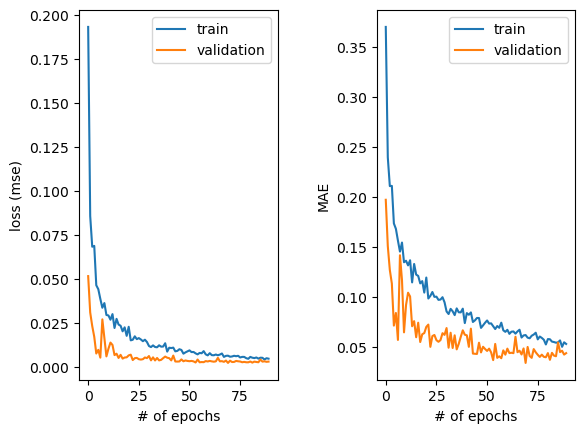

In [47]:
import matplotlib.pyplot as plt


def plot(history, path):
  #plotting
  fig, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 1, 'wspace': 0.5}) 
  (ax1, ax2) = axs
  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.legend(loc="upper right")
  ax1.set_xlabel("# of epochs")
  ax1.set_ylabel("loss (mse)")

  ax2.plot(history.history['mae'], label='train')
  ax2.plot(history.history['val_mae'], label='validation')
  ax2.legend(loc="upper right")
  ax2.set_xlabel("# of epochs")
  ax2.set_ylabel("MAE")

  plt.savefig(path)
    
plot(history, 'with_dropout.png')

#### Figure: learning curves with dropout

### Fitting model with optimal parameters

In [49]:
optimal_model = design_model()
optimal_model.fit(features_train_scaled, labels_train,  epochs=90, batch_size = 8, verbose = 1)
res_mse, res_mae = optimal_model.evaluate(features_test_scaled, labels_test, verbose = 0)
print(res_mse, res_mae)

Epoch 1/90
42/42 [==============================] - 3s 3ms/step - loss: 0.2876 - mae: 0.4518
Epoch 2/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0937 - mae: 0.2551
Epoch 3/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0657 - mae: 0.2095
Epoch 4/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0589 - mae: 0.1974
Epoch 5/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0554 - mae: 0.1909
Epoch 6/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0490 - mae: 0.1755
Epoch 7/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0471 - mae: 0.1724
Epoch 8/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0350 - mae: 0.1499
Epoch 9/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0382 - mae: 0.1513
Epoch 10/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0326 - mae: 0.1425
Epoch 11/90
42/42 [==============================] - 0s 3ms/step - lo

42/42 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0504
Epoch 89/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0041 - mae: 0.0487
Epoch 90/90
42/42 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0504
0.004441332072019577 0.048800647258758545


In [51]:
predicted_values = optimal_model.predict(features_test_scaled) 
print(r2_score(labels_test, predicted_values)) 

6/6 [==============================] - 0s 4ms/step
0.7844369481523427


With an R-squared score of approximately 0.8, a large proportion of the variance of our dependent variable; chance of admission score, can be explained by the various independent variables (test scores, etc). Hence, the model fits the data well.